In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [8]:
def impute_nan_with_median(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table   

In [9]:
data = pd.read_csv('desktop//data/credit_scoring_sample.csv', sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [10]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

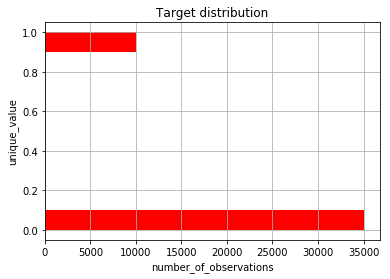

In [11]:
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target:')
data['SeriousDlqin2yrs'].value_counts() / data.shape[0]

In [12]:
independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [13]:
table = impute_nan_with_median(data)

In [14]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

In [15]:
#!pip install watermark
%load_ext watermark

In [16]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn -g

CPython 3.6.2
IPython 6.2.1

numpy 1.14.0
scipy 1.0.0
pandas 0.22.0
matplotlib 2.1.2
sklearn 0.19.1

compiler   : MSC v.1900 32 bit (Intel)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 32bit
Git hash   : HEAD


In [17]:
def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

# сохранение в отдельные numpy массивы данных по лояльным и уже бывшим клиентам
good = data[data['SeriousDlqin2yrs'] == 0]['MonthlyIncome'].values
bad = data[data['SeriousDlqin2yrs'] == 1]['MonthlyIncome'].values

# ставим seed для воспроизводимости результатов
np.random.seed(17)

# генерируем выборки с помощью бутстрэра и сразу считаем по каждой из них среднее
good_income_lower = [np.mean(sample) 
                       for sample in get_bootstrap_samples(good, 1000)]
bad_income_upper = [np.mean(sample) 
                       for sample in get_bootstrap_samples(bad, 1000)]

#  выводим интервальную оценку среднего
print("good:  mean interval",  stat_intervals(good_income_lower, 0.1))
print("bad:  mean interval",  stat_intervals(bad_income_upper, 0.1))

good:  mean interval [6295.93237577 6505.35467934]
bad:  mean interval [5471.64826451 5643.93562737]


In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [19]:
dt = DecisionTreeClassifier(random_state=17, class_weight='balanced')

In [20]:
max_depth_values = [5, 6, 7, 8, 9]
max_features_values = [4, 5, 6, 7]
tree_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

In [21]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

In [22]:
grid = GridSearchCV(dt, tree_params, scoring='roc_auc', cv = skf, verbose = True)

In [23]:
grid.fit(X,y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [5, 6, 7, 8, 9], 'max_features': [4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

In [24]:
grid.best_params_

{'max_depth': 7, 'max_features': 6}

In [25]:
grid.best_score_

0.8203023476209635

In [27]:
t = grid.cv_results_['std_test_score']
np.std(t)

0.0009009062587041476

In [ ]:
from __future__ import division, print_function
%pylab inline
np.random.seed(42)
figsize(8, 6)
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
n_train = 150        
n_test = 1000       
noise = 0.1

def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2)\
        + np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

rf = RandomForestRegressor(n_estimators=10).fit(X_train, y_train)
rf_predict = rf.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, rf_predict, "r", lw=2)
plt.xlim([-5, 5])
plt.title("Случайный лес, MSE = %.2f" % np.sum((y_test - rf_predict) ** 2));

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

class RandomForestClassifierCustom(BaseEstimator):
    def __init__(self, n_estimators=10, max_depth=10, max_features=10, 
                 random_state=17):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        
        self.trees = []
        self.feat_ids_by_tree = []
        
    def fit(self, X, y):
        for i in range(self.n_estimators):
            
            np.random.seed(i + self.random_state)
            
            feat_to_use_ids = np.random.choice(range(X.shape[1]), self.max_features, 
                                              replace=False)
            examples_to_use = list(set(np.random.choice(range(X.shape[0]), X.shape[0],
                                              replace=True)))
            
            self.feat_ids_by_tree.append(feat_to_use_ids)
            
            dt = DecisionTreeClassifier(class_weight='balanced',
                                        max_depth=self.max_depth, 
                                        max_features=self.max_features, 
                                        random_state = self.random_state)

            dt.fit(X[examples_to_use, :][:, feat_to_use_ids], y[examples_to_use])
            self.trees.append(dt)
        return self
    
    def predict_proba(self, X):
        predictions = []
        for i in range(self.n_estimators):
            feat_to_use_ids = self.feat_ids_by_tree[i]
            predictions.append(self.trees[i].predict_proba(X[:,feat_to_use_ids]))
        return np.mean(predictions, axis=0)

rf = RandomForestClassifierCustom(max_depth=7, max_features=6).fit(X.values, y.values)
cv_aucs = cross_val_score(RandomForestClassifierCustom(max_depth=7, max_features=6), 
                          X.values, y.values, scoring="roc_auc", cv=skf)
print("Средняя ROC AUC для случайного леса:", np.mean(cv_aucs))

cv_aucs = cross_val_score(RandomForestClassifier(n_estimators=10, max_depth=7, 
                                               max_features=6,
                                               random_state=17, n_jobs=-1,
                                              class_weight='balanced'), 
                        X.values, y.values, scoring="roc_auc", cv=skf)
print("Средняя ROC AUC для случайного леса Sklearn:", np.mean(cv_aucs))

In [ ]:

max_depth_values = range(5, 15)
max_features_values = [4, 5, 6, 7]
forest_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}
rf = RandomForestClassifier(random_state=17, n_jobs=-1, 
                            class_weight='balanced')
rf_grid_search = GridSearchCV(rf, forest_params, n_jobs=-1, 
                              scoring='roc_auc', cv=skf)
rf_grid_search.fit(X.values, y.values)
rf_grid_search.best_score_
rf_grid_search.best_params_
rf_grid_search.cv_results_["std_test_score"][np.argmax(rf_grid_search.cv_results_["mean_test_score"])]

In [ ]:
df = pd.read_csv("desktop/data/movie_reviews_train.csv", nrows=50000)

X_text = df["text"]
y_text = df["label"]

df.label.value_counts()

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

classifier = Pipeline([
    ('vectorizer', CountVectorizer(max_features = 100000, ngram_range = (1, 3))),
    ('clf', LogisticRegression(random_state=17))])

In [ ]:
%%time
parameters = {'clf__C': (0.1, 1, 10, 100)}
grid_search = GridSearchCV(classifier, parameters, n_jobs=-1, scoring ='roc_auc', cv=skf)
grid_search = grid_search.fit(X_text, y_text)
grid_search.best_params_
grid_search.best_score_

In [ ]:
classifier = Pipeline([
    ('vectorizer', CountVectorizer(max_features = 100000, ngram_range = (1, 3))),
    ('clf', RandomForestClassifier(random_state=17, n_jobs=-1))])

min_samples_leaf = [1, 2, 3]
max_features = [0.3, 0.5, 0.7]
max_depth = [None]


%%time
parameters = {'clf__max_features': max_features,
              'clf__min_samples_leaf': min_samples_leaf,
              'clf__max_depth': max_depth}
grid_search = GridSearchCV(classifier, parameters, n_jobs=-1, scoring ='roc_auc', cv=skf)
grid_search = grid_search.fit(X_text, y_text)
grid_search.best_params_
grid_search.best_score_